In [2]:
# import library
import pandas
import numpy as np
import math
import matplotlib.pyplot as plt

import pymoo
from pymoo.core.problem import Problem

import pandas as pd


import joblib

In [3]:
# import ML model

date = "0627"

ML_model_Llt = joblib.load(f'leakage_inductance_{date}.pkl')
ML_model_Lmt = joblib.load(f'magnetizing_inductance_{date}.pkl')
ML_model_Rt = joblib.load(f'Rt_{date}.pkl')
ML_model_Rr = joblib.load(f'Rr_{date}.pkl')

In [12]:

# core loss parameter
core_temp = 70

core_a = 0.6942
core_x = 1.4472
core_y = 2.4769
core_b = 4.7948
core_c = 0.0684
core_d = 4e-4
core_LT = core_b - core_c*core_temp + core_d*core_temp**2



# NSAG-II main

popsize = int(100/5)
offsprings = int(3000/5)

one1 = np.ones(offsprings)
one2 = np.ones(popsize)

#N11 = np.concatenate((4*one1,5*one1,6*one1,7*one1,8*one1,9*one1,10*one1,11*one1,12*one1,13*one1), axis=None)
#N12 = np.concatenate((4*one2,5*one2,6*one2,7*one2,8*one2,9*one2,10*one2,11*one2,12*one2,13*one2), axis=None)\

N11 = np.concatenate((8*one1,9*one1,10*one1,11*one1,12*one1), axis=None)
N12 = np.concatenate((8*one2,9*one2,10*one2,11*one2,12*one2), axis=None)

freq = 30e+3

per = 3500

b_N1 = [6,12]
b_w1 = [30,200]
b_l1 = [10,50]
b_l2 = [50,110]
b_h1 = [50,200]
b_per = [3500,3500]
b_space1 = [20,50]
b_space2 = [20,50]
b_space3 = [5,50]
b_space4 = [5,50]
b_coil_width1 = [30,100]
b_coil_width2 = [30,100]
b_move_z1 = [10,50]
b_move_z2 = [10,50]
b_offset_z1 = [-20,20]
b_offset_z2 = [-20,20]


class MyProblem(Problem):
    def __init__(self, ML_model_Llt, ML_model_Lmt, ML_model_Rt, ML_model_Rr):
        super().__init__(n_var=16,     #number of inputs
                         n_obj=2,     #number of outputs
                         n_constr=40,  #nubmer of constraints
                         xl=np.array([b_N1[0],b_w1[0],b_l1[0],b_l2[0],b_h1[0],b_per[0],b_space1[0],b_space2[0],b_space3[0],b_space4[0],
                         b_coil_width1[0],b_coil_width2[0],b_move_z1[0],b_move_z2[0],b_offset_z1[0],b_offset_z2[0]]), #input lower bounds
                         xu=np.array([b_N1[1],b_w1[1],b_l1[1],b_l2[1],b_h1[1],b_per[1],b_space1[1],b_space2[1],b_space3[1],b_space4[1],
                         b_coil_width1[1],b_coil_width2[1],b_move_z1[1],b_move_z2[1],b_offset_z1[1],b_offset_z2[1]])) #input upper bounds
        self.ML_model_Llt = ML_model_Llt
        self.ML_model_Lmt = ML_model_Lmt
        self.ML_model_Rt = ML_model_Rt
        self.ML_model_Rr = ML_model_Rr




# ["N1","w1","l1","l2","h1","space1","space2","space3","space4","coil_width1","coil_width2","move_z1","move_z2","offset_z1","offset_z2","freq","Llt","Llr"]
# ["N1","w1","l1","l2","h1","space1","space2","space3","space4","coil_width1","coil_width2","strand1","strand2","move_z1","move_z2","offset_z1","offset_z2","freq","Llt","Llr"]
    def _evaluate(self, X, out, *args, **kwargs):

        X[:,10] = X[:,10]*1e-1
        X[:,11] = X[:,11]*1e-1
        X[:,12] = X[:,12]*1e-1
        X[:,13] = X[:,13]*1e-1
        
        Y = X
        Y = np.concatenate((Y,Y[:,14:]),axis=1)
        Y[:,13:] = Y[:,11:-2]

        Y[:,12] = Y[:,10]**2 / 0.1**2 * 0.5
        Y[:,13] = Y[:,11]**2 / 0.1**2 * 0.5

        #try :
        #    X[:,0] = N11
        #except :
        #    X[:,0] = N12

        N1 = X[:,0] 

        w1 = X[:,1] * 1e-3
        l1 = X[:,2] * 1e-3
        l2 = X[:,3] * 1e-3
        h1 = X[:,4] * 1e-3

        per = X[:,5] 

        space1 = X[:,6] * 1e-3 # 1차 측 w 방향
        space2 = X[:,7] * 1e-3 # 1차 측 l 방향
        space3 = X[:,8] * 1e-3 # 2차 측 w 방향
        space4 = X[:,9] * 1e-3 # 2차 측 l 방향

        coil_width1 = X[:,10] * 1e-3
        coil_width2 = X[:,11] * 1e-3

        move_z1 = X[:,12] * 1e-3
        move_z2 = X[:,13] * 1e-3

        offset_z1 = X[:,14] * 1e-3
        offset_z2 = X[:,15] * 1e-3


        V1 = 1036
        I1 = 100
        I2 = 100

        l = 2*l1 + l2 + space2 + space4 + coil_width1/2 + coil_width2/2
        l_inner = space2 + space4 + coil_width1/2 + coil_width2/2
        h = 2*l1 + h1
        wp = 1*w1 + 2*space1 + coil_width1
        ws = 1*w1 + 2*space3 + coil_width2

        hp = (N1+1)*coil_width1 + N1*move_z1 + 2*abs(offset_z1)
        hs = (N1+1)*coil_width2 + N1*move_z2 + 2*abs(offset_z2)

        
        # Lmt
        f1 = self.ML_model_Lmt.predict( X ) # [unit : mH]
        Lmt = f1 * 1e-6 # [unit : H]

        # total volume
        f2 = l * h * wp   # Volume [Unit : m^3]
        f3 = l * h * ws   # Volume [Unit : m^3]

        V = f2

        A = l * wp
        
        V_core = (2*l1+l2)*h*w1 - l2*h*w1 # Core volume [unit : m^3]

        mag_current = V1/(2*3.141592*freq)/Lmt
        Req = N1**2/Lmt
        flux = N1 * mag_current/Req
        B = flux / (2*w1*l1)
        #B = V1 / (2*l1*w1) / (2*3.141592*freq) / N1

        #coreloss = core_a * freq**core_x * B**core_y * core_LT * V_core # Core loss [unit : W]
        coreloss = 6.5 * (freq/1e+3)**1.51 * B**1.74 * V_core / 1e-3
        f4 = coreloss

        f5 = self.ML_model_Rt.predict( Y ) * I1**2 # copperloss_tx [unit : W]
        f6 = self.ML_model_Rr.predict( Y ) * I2**2 # copperloss_rx [unit : W]

        f7 = f4*1+f5*5+f6*1 # total loss [unit : W]

        f8 = self.ML_model_Llt.predict( X ) # [unit : uH]
        Llt = f8 * 1e-6 # [unit : H]
        #print(np.average(Llt[0]*1e+6))



        #gLlt1 = -(Llt * 1.5 - 16.77e-6) * (Llt * 0.5 - 16.77e-6) / 5e-12 * 10 # Llt constraint
        #gLlt2 = -(Llt * 1.05 - 16.77e-6) * (Llt * 0.95 - 16.77e-6) / 5e-12 * 1 # Llt constraint
        gLlt = -(Llt * 1.02 - 32.375e-6 * 1) * (Llt * 0.98 - 32.375e-6 * 1) / 100e-12 * 10 # Llt constraint
        gLmt = -(Lmt - 500e-6) * (Lmt - 10e-3) / 500e-12
        #print(np.average(gLlt))

        gspace1 = - (space1 - coil_width1 - 20e-3) * (space1 - 50e-3) / 10e-6 # 1차측 w방향
        gspace2 = - (space2 - coil_width1 - 20e-3) * (space2 - 50e-3) / 10e-6 # 1차측 l방향
        gspace3 = - (space3 - coil_width2 - 5e-3) * (space3 - 20e-3) / 10e-6 # 2차측 w방향
        gspace4 = - (space4 - coil_width2 - 5e-3) * (space4 - 20e-3) / 10e-6 # 2차측 l방향
        gspace = -(ws - 0e-3) * (ws - wp) / 1e-6

        gl = -(l-0e-3)*(l-250e-3) / 200e-6
        gl2 = -(l2-l_inner-50e-3)*(l2-500e-3) / 400e-3

        gh = -(h-0e-3)*(h-150e-3) / 160e-6
        ghp = -(h1-hp-25e-3*2) * (h1 - 400e-3) / 400e-3
        ghs = -(h1-hs-5e-3*2) * (h1 - 400e-3) / 400e-3


        gwp = -(wp-0e-3)*(wp-180e-3) / 250e-6
        gws = -(ws-0e-3)*(ws-180e-3) / 250e-6

        

        gB = -(B-0)*(B-1)
        #gB = -(B-0)*(B-0.3)

        #gV = -(f2-f3) / 1e-3
        #print(X)
        print(np.average(B))
        print(f'min : {np.min(N1)}, max : {np.max(N1)}, avg : {np.average(N1)}')

        
        """
        g1 = g_N1
        g2 = gLlt3
        g1 = gspace1
        g2 = gspace2
        g3 = gspace3
        g4 = gspace4
        g5 = gh11
        g6 = gh12
        g7 = gl
        g8 = gh
        g9 = gw
        g10 = gB
        g11= g_ins1
        g12 = g_ins2
        g13 = g_ins3
        g14 = g_ins4
        g15 = g_air1
        g16 = g_air2
        g17 = g_air3
        g18 = g_air4
        """

        #g_space = [g2,g3,g4,g5,g6,g7,g8,g9,g10,g11,g12,g13,g14,g15,g16,g17,g18]
        #g_space = [g1.T,g2.T,g3.T,g4.T,g5.T,g6.T,g7.T,g8.T,g9.T,g10.T,g11.T,g12.T,g13.T,g14.T,g15.T,g16.T,g17.T,g18.T]
        #g_space = np.swapaxes(g_space,0,1)
        #g_space = np.where(g_space<0 , 0 , g_space)
        #vec = np.vectorize(math.clamp(X,0))

        #print(g_space[0])


        out["F"] = np.column_stack([V, f7]) # "Minimize" values (volume, coreloss)
        out["G"] = np.column_stack([gLlt, gLmt, gspace1, gspace2, gspace3, gspace4, gspace, gl, gl2, gh, ghp, ghs, gwp, gws, gB])
        
        out["G"] = - out["G"] # Actually < 0 

problem = MyProblem(ML_model_Llt, ML_model_Lmt, ML_model_Rt, ML_model_Rr)


In [13]:
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.factory import get_sampling, get_crossover, get_mutation
from pymoo.operators.mixed_variable_operator import MixedVariableSampling, MixedVariableMutation, MixedVariableCrossover

# ["N1","w1","l1","l2","h1","space1","space2","space3","space4","coil_width1","coil_width2","move_z1","move_z2","offset_z1","offset_z2","freq","Llt","Llr"]
mask = ["int", "int", "int", "int", "int", "int", "int", "int", "int", "int", "int", "int", "int", "int", "int","int"]

algorithm = NSGA2(
    pop_size=100,
    n_offsprings=3000,

    sampling = MixedVariableSampling(mask, {
        "int": get_sampling("int_random")
    }),

    crossover = MixedVariableCrossover(mask, {
        "int": get_crossover("int_sbx", prob=0.3, eta=10)
    }),

    #mutation=get_mutation("real_pm", eta=40),
    mutation = MixedVariableMutation(mask, {
        "int": get_mutation("int_pm", eta=0.01)
    }),

    eliminate_duplicates=True
)

In [14]:
from pymoo.factory import get_termination

termination = get_termination("n_gen", 10000)

In [15]:
from pymoo.optimize import minimize

res = minimize(problem,
               algorithm,
               termination,
               seed=15, #RANDOM SEED
               save_history=False,
               verbose=True)
res

#print("Best solution found: %s" % res.X)
#print("Function value: %s" % res.F)
#print("Constraint violation: %s" % res.CV)

0.1410218682511271
min : 6, max : 12, avg : 8.97
n_gen |  n_eval |   cv (min)   |   cv (avg)   |  n_nds  |     eps      |  indicator  
    1 |     100 |  0.244301785 |  1.43491E+02 |       1 |            - |            -
0.14926493843825736
min : 6, max : 12, avg : 8.945
    2 |    3100 |  0.119158538 |  0.904240375 |       1 |  3.86466E+02 |        ideal
0.2981750658722171
min : 6, max : 12, avg : 9.695
    3 |    6100 |  0.004347650 |  0.052342828 |       1 |  1.02671E+02 |        ideal
0.3526784109596644
min : 6, max : 12, avg : 9.920333333333334
    4 |    9100 |  0.002256475 |  0.006052668 |       1 |  6.67497E+01 |        ideal
0.3238695555346429
min : 6, max : 12, avg : 8.669333333333332
    5 |   12100 |  0.001790642 |  0.003270139 |       1 |  0.504936282 |        ideal
0.3327750830209354
min : 6, max : 12, avg : 8.493666666666666
    6 |   15100 |  0.000858267 |  0.002058208 |       1 |  5.14586E+01 |        ideal
0.3489245870241005
min : 6, max : 12, avg : 8.393666666666666


519.6666173069317

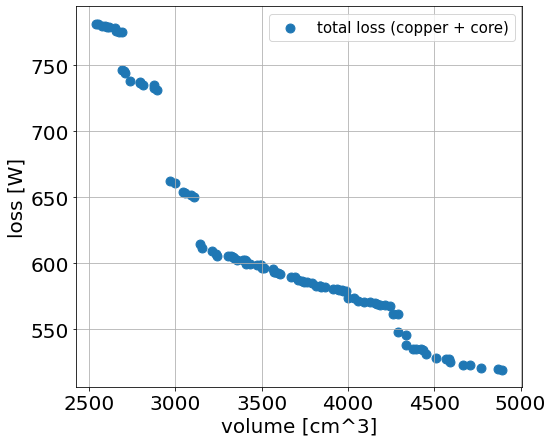

In [31]:
plt.rcParams["figure.figsize"] = (8,7)

parameters = {'xtick.labelsize' : 20,
          'ytick.labelsize' : 20}
plt.rcParams.update(parameters)

plt.scatter(res.F[:,0]*1e+6, res.F[:,1] ,s=80)
plt.xlabel("volume [cm^3]", fontsize=20)
plt.ylabel("loss [W]", fontsize=20)
plt.grid(True)
plt.legend(["total loss (copper + core)"], fontsize=15)

min(res.F[:,1])

In [34]:
res.F[1,0]*1e+6

2490.84

In [35]:
res.X[1]

array([8, 50, 19, 110, 98, 3500, 23, 23, 14, 10, 3, 5, 3, 5, -15, 1],
      dtype=object)

In [36]:
res.X[1]

array([8, 50, 19, 110, 98, 3500, 23, 23, 14, 10, 3, 5, 3, 5, -15, 1],
      dtype=object)

In [16]:


res.X[:,10] = res.X[:,10]*1e-1
res.X[:,11] = res.X[:,11]*1e-1
res.X[:,12] = res.X[:,12]*1e-1
res.X[:,13] = res.X[:,13]*1e-1


Y = res.X
Y = np.concatenate((Y,Y[:,14:]),axis=1)
Y[:,13:] = Y[:,11:-2]

Y[:,12] = Y[:,10]**2 / 0.1**2 * 0.5
Y[:,13] = Y[:,11]**2 / 0.1**2 * 0.5

N1 = res.X[:,0] 

w1 = res.X[:,1] * 1e-3
l1 = res.X[:,2] * 1e-3
l2 = res.X[:,3] * 1e-3
h1 = res.X[:,4] * 1e-3

strand1 = Y[:,12]
strand2 = Y[:,13]

per = res.X[:,5]

space1 = res.X[:,6] * 1e-3
space2 = res.X[:,7] * 1e-3
space3 = res.X[:,8] * 1e-3
space4 = res.X[:,9] * 1e-3

coil_width1 = res.X[:,10] * 1e-3
coil_width2 = res.X[:,11] * 1e-3

move_z1 = res.X[:,12] * 1e-3
move_z2 = res.X[:,13] * 1e-3

offset_z1 = res.X[:,14] * 1e-3
offset_z2 = res.X[:,15] * 1e-3

V1 = 1036
I1 = 100
I2 = 100

l = 2*l1 + l2 + space2 + space4 + coil_width1/2 + coil_width2/2
l_inner = space2 + space4 + coil_width1/2 + coil_width2/2
h = 2*l1 + h1
wp = 1*w1 + 2*space1 + coil_width1
ws = 1*w1 + 2*space3 + coil_width2
w = wp

hp = (N1+1)*coil_width1 + N1*move_z1 + 2*abs(offset_z1)
hs = (N1+1)*coil_width2 + N1*move_z2 + 2*abs(offset_z2)


X_column = ["N1","w1","l1","l2","h1","per","space1","space2","space3","space4","coil_width1","coil_width2","move_z1","move_z2","offset_z1","offset_z2"]
X_data = pd.DataFrame(res.X, columns=X_column)
X_data = X_data.astype(float)
#X_data = pd.to_numeric(X_data)


Lmt = ML_model_Lmt.predict( X_data )

V = l * h * wp

V_core = (2*l1+l2)*h*w1 - l2*h*w1

mag_current = V1/(2*3.141592*freq)/Lmt
Req = N1**2/Lmt
flux = N1 * mag_current/Req
B = flux / (2*w1*l1)

#coreloss = core_a * freq**core_x * B**core_y * core_LT * V_core # Core loss [unit : W]

coreloss1 = core_a * freq**core_x * B**core_y * core_LT * V_core # Core loss [unit : W]
coreloss2 = 6.5 * (freq/1e+3)**1.51 * B**1.74 * V_core / 1e-3

coreloss = coreloss2

copperloss_tx = ML_model_Rt.predict( Y ) * I1**2
copperloss_rx = ML_model_Rr.predict( Y ) * I2**2

total_loss = coreloss + copperloss_tx + copperloss_rx
copperloss = copperloss_tx + copperloss_rx

Llt = ML_model_Llt.predict( X_data )

In [41]:
V_core

array([0.00094582, 0.0005932800000000001, 0.0009458199999999998,
       0.0004963200000000002, 0.0004320000000000001,
       0.00046367999999999995, 0.00046367999999999995, 0.00056448,
       0.00046368000000000017, 0.00068544, 0.0005932800000000003,
       0.00046368000000000017, 0.00046367999999999973,
       0.0005932800000000003, 0.00046367999999999973,
       0.0002870399999999999, 0.00056448, 0.0006278400000000002,
       0.00026026, 0.0002574000000000001, 0.0005644800000000002,
       0.0005015999999999998, 0.00025739999999999986,
       0.0005644800000000002, 0.00062784, 0.00046368000000000017,
       0.0005544, 0.0005932800000000003, 0.00026226199999999965,
       0.0009557759999999998, 0.00025938000000000003,
       0.00025938000000000024, 0.00025938000000000003, 0.000289248,
       0.0009458199999999998, 0.0005932800000000003,
       0.0006621159999999999, 0.0005990399999999999,
       0.00047376000000000015, 0.0006565520000000001, 0.00098914,
       0.000999552, 0.000519120

In [ ]:
np.transpose(np.concatenate([[V*1e+6],[copperloss_tx],[copperloss_rx]],axis=0)).shape

In [17]:
pd.set_option('display.max_columns', 50)
pd.set_option('display.max_rows', 100)

result_data = pd.concat([X_data,pd.DataFrame(np.transpose(np.concatenate([[V*1e+6],[B],[Lmt],[Llt],[w*1e+3],[l*1e+3],[h*1e+3],[total_loss],[copperloss_tx],[copperloss_rx],[copperloss],[coreloss]],axis=0)),columns=["V","B","Lmt","Llt","w","l","h","total_loss","copperloss_tx","copperloss_rx","copperloss","coreloss"])], axis=1)



result_data = result_data.sort_values('w', ascending=True) # 정렬

#result_data.to_csv("./result/result_0628_F151_N3000_amorphous_h25_hlimit150_res0.1.csv")


result_data = result_data[result_data["copperloss_tx"]<90]


result_data



,N1,w1,l1,l2,h1,per,space1,space2,space3,space4,coil_width1,coil_width2,move_z1,move_z2,offset_z1,offset_z2,V,B,Lmt,Llt,w,l,h,total_loss,copperloss_tx,copperloss_rx,copperloss,coreloss
93,8.0,40.0,23.0,99.0,103.0,3500.0,25.0,25.0,10.0,10.0,5.0,5.0,1.0,1.2,0.0,-16.0,2618.675,0.37338,561.102928,31.746298,95.0,185.0,149.0,104.595428,27.593414,22.437143,50.030557,54.564871
87,8.0,40.0,23.0,97.0,103.0,3500.0,25.0,25.0,10.0,10.0,5.0,4.7,1.0,1.2,0.0,-17.0,2588.24175,0.37338,561.085941,31.837346,95.0,182.85,149.0,105.720337,27.514724,23.640742,51.155466,54.564871
56,8.0,40.0,23.0,106.0,103.0,3500.0,25.0,25.0,12.0,11.0,5.0,5.7,1.0,1.0,0.0,16.0,2736.86925,0.37338,527.731698,31.746464,95.0,193.35,149.0,98.606461,27.399993,16.641597,44.04159,54.564871
5,8.0,40.0,23.0,107.0,103.0,3500.0,25.0,25.0,17.0,11.0,5.0,5.7,1.0,1.0,0.0,16.0,2751.02425,0.37338,529.162299,31.74395,95.0,194.35,149.0,98.752556,27.316715,16.87097,44.187685,54.564871
14,8.0,40.0,23.0,104.0,103.0,3500.0,25.0,25.0,12.0,11.0,5.0,5.4,1.0,1.0,0.0,-10.0,2706.436,0.37338,521.326787,31.748628,95.0,191.2,149.0,101.699687,27.500187,19.634629,47.134816,54.564871
78,8.0,40.0,23.0,100.0,103.0,3500.0,25.0,25.0,10.0,10.0,5.0,4.7,1.0,1.0,0.0,20.0,2630.70675,0.37338,554.951279,31.928887,95.0,185.85,149.0,105.05425,27.202855,23.286524,50.489379,54.564871
62,8.0,40.0,23.0,104.0,103.0,3500.0,25.0,25.0,12.0,11.0,5.0,5.7,1.0,1.0,0.0,-10.0,2708.55925,0.37338,521.326787,31.748628,95.0,191.35,149.0,98.727403,27.505023,16.65751,44.162532,54.564871
92,8.0,40.0,23.0,98.0,103.0,3500.0,25.0,25.0,10.0,10.0,5.0,4.7,1.0,1.2,0.0,-4.0,2602.39675,0.37338,556.752204,31.778879,95.0,183.85,149.0,105.603399,27.418432,23.620096,51.038528,54.564871
10,8.0,40.0,23.0,100.0,103.0,3500.0,25.0,25.0,11.0,11.0,5.0,5.2,1.0,1.0,0.0,19.0,2648.4005,0.37338,550.664775,31.79173,95.0,187.1,149.0,103.242291,27.406723,21.270698,48.67742,54.564871
53,8.0,46.0,19.0,100.0,103.0,3500.0,25.0,25.0,10.0,10.0,5.0,4.7,1.0,1.0,0.0,-8.0,2532.76185,0.393031,518.940379,31.783692,101.0,177.85,141.0,106.62664,28.907368,24.086467,52.993835,53.632804


In [100]:
pd.set_option('display.max_columns', 50)
pd.set_option('display.max_rows', 10)

gLlt = -(Llt * 1.02 - 32.375e-6 * 1) * (Llt * 0.98 - 32.375e-6) / 100e-12 * 1 * 10 # Llt constraint
gLmt = -(Lmt - 500e-6) * (Lmt - 10e-3) / 500e-12
#print(np.average(gLlt))

gspace1 = - (space1 - coil_width1 - 20e-3) * (space1 - 50e-3) / 10e-6 # 1차측 w방향
gspace2 = - (space2 - coil_width1 - 20e-3) * (space2 - 50e-3) / 10e-6 # 1차측 l방향
gspace3 = - (space3 - coil_width2 - 5e-3) * (space3 - 20e-3) / 10e-6 # 2차측 w방향
gspace4 = - (space4 - coil_width2 - 5e-3) * (space4 - 20e-3) / 10e-6 # 2차측 l방향
gspace = -(ws - 0e-3) * (ws - wp) / 1e-6

gl = -(l-0e-3)*(l-250e-3) / 250e-6
gl2 = -(l2-l_inner-50e-3)*(l2-500e-3) / 400e-3

gh = -(h-0e-3)*(h-140e-3) / 160e-6
ghp = -(h1-hp-10e-3) * (h1 - 400e-3) / 400e-3
ghs = -(h1-hs-10e-3) * (h1 - 400e-3) / 400e-3


gwp = -(wp-0e-3)*(wp-180e-3) / 250e-6
gws = -(ws-0e-3)*(ws-180e-3) / 250e-6

gB = -(B-0)*(B-1.0)


g_column = ["gLlt","gLmt","gspace1","gspace2","gspace3","gspace4","gspace","gl","gl2","gh","ghp","ghs","gwp","gws","gB"]
g_data = np.transpose(np.concatenate([[gLlt],[gLmt],[gspace1],[gspace2],[gspace3],[gspace4],[gspace],[gl],[gl2],[gh],[ghp],[ghs],[gwp],[gws],[gB]],axis=0))
g_data = pd.DataFrame(g_data, columns=g_column)

#g_column = ["gLlt","gLmt","gspace1","gspace2","gspace3","gspace4","gspace","gl","gl2","gh","ghp","ghs","gwp","gws"]
#g_data = [[gLlt,gLmt,gspace1,gspace2,gspace3,gspace4,gspace,gl,gl2,gh,ghp,ghs,gwp,gws]]
#g_data = pd.DataFrame(g_data, columns=g_column)

g_data

,gLlt,gLmt,gspace1,gspace2,gspace3,gspace4,gspace,gl,gl2,gh,ghp,ghs,gwp,gws,gB
0,-103729387980945.875,-1746963079643664.0,0.0,0.0,0.0,0.0,2400.0,58.656,0.0,28.6,0.004375,-0.004375,30.8,32.0,0.208541
1,-104824564754574.65625,-2441402144834338.5,0.0,0.0,0.0,0.0,2727.0,31.875,0.020962,0.86875,0.004062,-0.002438,26.624,31.916,0.135366
2,-108261468525202.96875,-1646186737298577.25,0.0,0.0,2.4,2.1,1634.0,35.931,0.011299,2.56875,0.003962,-0.00317,31.5,32.336,0.182425
3,-100750802355493.890625,-2735967821658756.5,0.0,0.0,1.6,0.0,2300.0,40.299,0.008564,8.125,0.00501,-0.004175,28.044,32.0,0.142935
4,-105857298085814.0625,-2116591749308471.5,0.0,0.0,2.8,0.0,1615.0,56.571,0.000518,27.6,0.004375,-0.0035,31.616,32.3,0.208958
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,-105844007833073.890625,-1935347860493309.25,0.0,0.0,2.8,0.0,1782.0,48.1,0.013,22.06875,0.004262,-0.002558,31.724,32.076,0.201883
96,-100948776353194.125,-2736696202363148.5,0.0,0.0,1.6,0.0,2277.0,39.699,0.007575,5.025,0.00415,-0.00415,28.304,32.076,0.141066
97,-102030938223614.34375,-1942117071339973.25,0.0,0.0,2.8,0.0,1577.0,54.219,0.005624,24.225,0.004275,-0.00342,31.824,32.204,0.207813
98,-108823970588745.8125,-2085197973144599.0,0.0,0.0,2.8,0.0,1118.0,53.851,0.000518,25.0,0.004375,-0.0035,32.076,32.336,0.199288


163.8836813252901

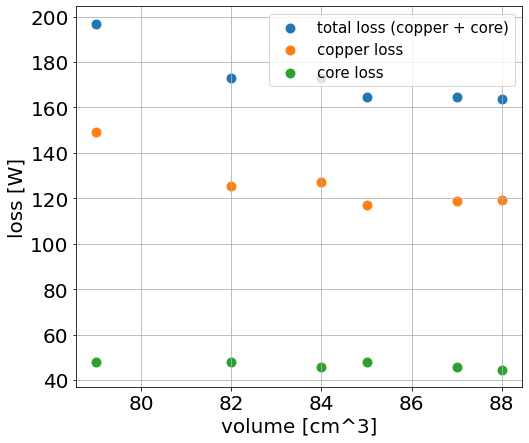

In [40]:
plt.rcParams["figure.figsize"] = (8,7)

parameters = {'xtick.labelsize' : 20,
          'ytick.labelsize' : 20}
plt.rcParams.update(parameters)

#plt.scatter(V*1e+6, total_loss ,s=80)
#plt.scatter(V*1e+6, copperloss ,s=80)
#plt.scatter(V*1e+6, coreloss ,s=80)
plt.scatter(w*1e+3, total_loss ,s=80)
plt.scatter(w*1e+3, copperloss ,s=80)
plt.scatter(w*1e+3, coreloss ,s=80)
plt.xlabel("volume [cm^3]", fontsize=20)
plt.ylabel("loss [W]", fontsize=20)
plt.grid(True)
plt.legend(["total loss (copper + core)","copper loss","core loss"], fontsize=15)

min(res.F[:,1])

162.32018701492404

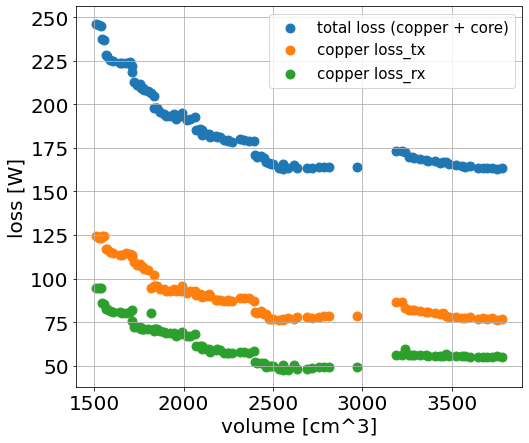

In [102]:
plt.rcParams["figure.figsize"] = (8,7)

parameters = {'xtick.labelsize' : 20,
          'ytick.labelsize' : 20}
plt.rcParams.update(parameters)

plt.scatter(V*1e+6, total_loss ,s=80)
plt.scatter(V*1e+6, copperloss_tx ,s=80)
plt.scatter(V*1e+6, copperloss_rx ,s=80)
plt.xlabel("volume [cm^3]", fontsize=20)
plt.ylabel("loss [W]", fontsize=20)
plt.grid(True)
plt.legend(["total loss (copper + core)","copper loss_tx","copper loss_rx"], fontsize=15)

min(res.F[:,1])

162.32018701492404

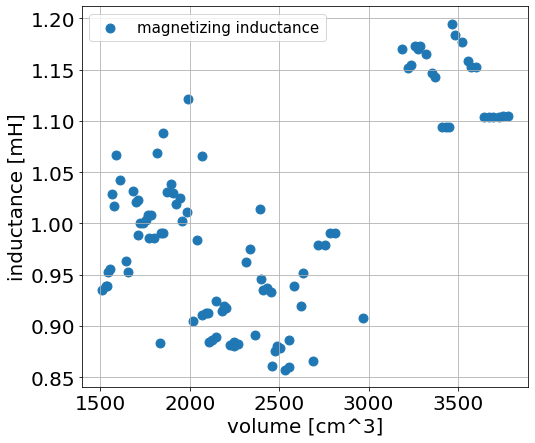

In [106]:
plt.rcParams["figure.figsize"] = (8,7)

parameters = {'xtick.labelsize' : 20,
          'ytick.labelsize' : 20}
plt.rcParams.update(parameters)

plt.scatter(V*1e+6, Lmt*1e-3 ,s=80)
plt.xlabel("volume [cm^3]", fontsize=20)
plt.ylabel("inductance [mH]", fontsize=20)
plt.grid(True)
plt.legend(["magnetizing inductance"], fontsize=15)

min(res.F[:,1])

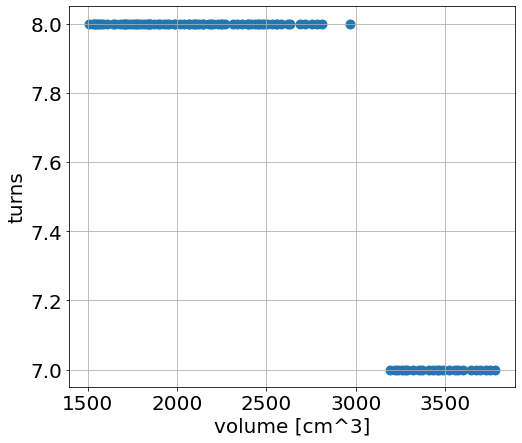

In [107]:
plt.rcParams["figure.figsize"] = (8,7)

parameters = {'xtick.labelsize' : 20,
          'ytick.labelsize' : 20}
plt.rcParams.update(parameters)

plt.scatter(V*1e+6, N1 ,s=80)
plt.xlabel("volume [cm^3]", fontsize=20)
plt.ylabel("turns", fontsize=20)
plt.grid(True)
#plt.legend(["turns"], fontsize=15)


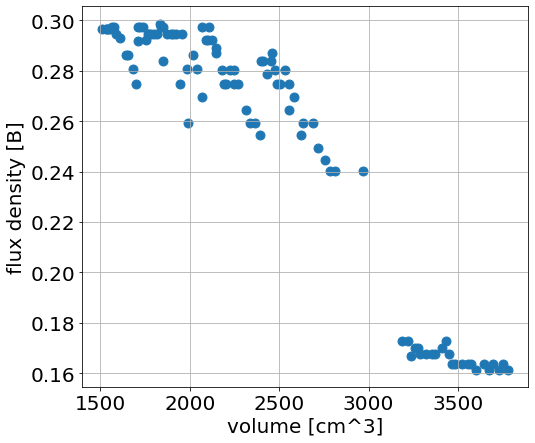

In [105]:
plt.rcParams["figure.figsize"] = (8,7)

parameters = {'xtick.labelsize' : 20,
          'ytick.labelsize' : 20}
plt.rcParams.update(parameters)

plt.scatter(V*1e+6, B ,s=80)
plt.xlabel("volume [cm^3]", fontsize=20)
plt.ylabel("flux density [B]", fontsize=20)
plt.grid(True)
#plt.legend(["turns"], fontsize=15)
